In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import spatial
from surprise import Reader
from surprise.dataset import DatasetAutoFolds
from tqdm import tqdm

## Data loading

In [2]:
DATA_ROOT='../../data'

model = pd.read_pickle('../notebooks_data/SVD_model.pkl')

In [3]:
columns = ['bgg_user_name', 'bgg_id', 'bgg_user_rating']
train_df = pd.read_csv(f'{DATA_ROOT}/ratings_train_explicit.csv.gz')[columns]
train_df_implicit = pd.read_csv(f'{DATA_ROOT}/ratings_train_implicit.csv.gz')
test_df = pd.read_csv(f'{DATA_ROOT}/ratings_test_explicit.csv.gz')[columns]
features_names = pd.read_csv(f'{DATA_ROOT}/game_features_names.csv.gz').values.flatten()
games_features_df = pd.read_json(f'{DATA_ROOT}/bgg_GameItem.jl', lines=True)\
[['bgg_id', 'mechanic', 'category', 'complexity', 'max_players_best', 'min_players_best', 'max_players_rec', 'min_players_rec']]

reader = Reader(rating_scale=(1, 10))
dataset = DatasetAutoFolds.load_from_df(train_df, reader).build_full_trainset()

In [4]:
users_profiles = pd.read_pickle(f'{DATA_ROOT}/users_profiles.pkl')

In [5]:
users_profiles.values[:, :40] *= 3

## Utils

In [6]:
def get_user_embedding(model, dataset, user_name):
    user_id = dataset.to_inner_uid(user_name)
    return model.pu[user_id]

def get_user_bias(model, dataset, user_name):
    user_id = dataset.to_inner_uid(user_name)
    return model.bu[user_id]
    
def get_game_embedding(model, dataset, bgg_game_id):
    game_id = dataset.to_inner_iid(bgg_game_id)
    return model.qi[game_id]
    
def get_game_bias(model, dataset, bgg_game_id):
    game_id = dataset.to_inner_iid(bgg_game_id)
    return model.bi[game_id]

def similarity(p1, p2):
    # maybe lets use euclidean distance here
    return 1 - spatial.distance.cosine(p1, p2)

In [7]:
train_df_implicit = train_df_implicit[train_df_implicit.bgg_user_name.isin(train_df.bgg_user_name)]

## Testing

In [8]:
train_counts = train_df_implicit['bgg_user_name'].value_counts()
users = train_counts[train_counts >= 10].index.values

In [9]:
random_users = np.random.choice(users, size=10001, replace=False)
u0 = random_users[0]
p0 = users_profiles.iloc[users_profiles.index == u0]
e0 = get_user_embedding(model=model, dataset=dataset, user_name=u0)
embedding_similarity = []
preferences_similarity = []
for ui in tqdm(random_users[1:]):
    pi = users_profiles.iloc[users_profiles.index == ui]
    ei = get_user_embedding(model=model, dataset=dataset, user_name=ui)
    embedding_similarity.append(similarity(e0, ei))
    preferences_similarity.append(similarity(p0, pi))

100%|██████████| 10000/10000 [02:00<00:00, 83.09it/s]


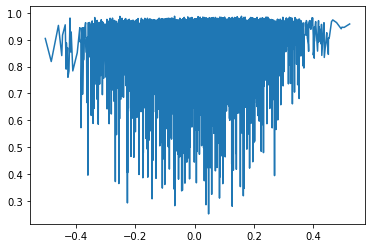

In [10]:
embedding_similarity = np.array(embedding_similarity)
preferences_similarity = np.array(preferences_similarity)
idx = np.argsort(embedding_similarity)
plt.plot(embedding_similarity[idx], preferences_similarity[idx])

Text(0, 0.5, 'Profiles similarity')

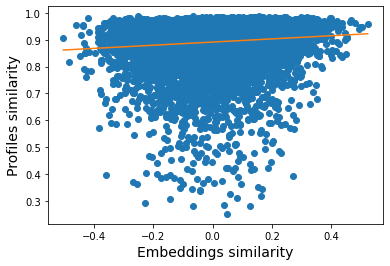

In [11]:
m, b = np.polyfit(x=embedding_similarity[idx], y=preferences_similarity[idx], deg=1)
plt.plot(embedding_similarity[idx], preferences_similarity[idx], 'o')
plt.plot(embedding_similarity[idx], m*embedding_similarity[idx] + b)
plt.xlabel("Embeddings similarity", fontsize=14)
plt.ylabel("Profiles similarity", fontsize=14)